<a href="https://colab.research.google.com/github/soosung80/capstone-210-fall2022/blob/main/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Training Dataset

In [ ]:
!pip install user_functions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement user_functions (from versions: none)
ERROR: No matching distribution found for user_functions


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.4 MB/s 
     |████████████████████████████████| 182 kB 72.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 


In [ ]:
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
# from user_functions import *
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')
import torch

from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
aisles = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/aisles.csv")
departments = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/departments.csv")
# order_products_prior = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/order_products__prior.csv")
# order_products_train = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/order_products__train.csv")
# orders = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/orders.csv")
products = pd.read_csv("gdrive/My Drive/capstone project - shared/datasets/products.csv")

In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
#merge datasets
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
combined_df = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
combined_df.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [ ]:
len(combined_df)

49688

In [ ]:
combined_df.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

In [ ]:
combined_df.duplicated(["product_name"]).sum()

0

In [ ]:
combined_df.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
aisle            object
department       object
dtype: object

In [ ]:
#separate 80-20 train and test 
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(combined_df, test_size=0.2, random_state=25)
# train_subcategory_aisle,test_category_aisle =train_test_split(train_data, test_size=0.2, random_state=25)
print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")


No. of training examples: 39750
No. of testing examples: 9938


In [ ]:
train_data = train_data.set_index("product_id")
test_data = test_data.set_index("product_id")
train_data.head()
test_data.head()

,product_name,aisle_id,department_id,aisle,department
product_id,,,,,
34789,Light Vanilla Soymilk,91,16,soy lactosefree,dairy eggs
31871,Beef Polska Kielbasa,106,12,hot dogs bacon sausage,meat seafood
1070,Spicy Chicken Breast Patties,34,1,frozen meat seafood,frozen
10103,Fluffy Marshmallow Frosting,97,13,baking supplies decor,pantry
9695,Goldfish Baked Snack Crackers Variety Pack,78,19,crackers,snacks


In [ ]:
train_data.to_json("/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/train_v3.json",orient='index')
test_data.to_json("/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/test_v3.json",orient='index')

In [ ]:
# #save as json to google drive
# path="/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model"

# for i in range(0,len(train_data["product_id"])):
#   print(i)
#   for j in range(0,len(train_data["product_id"][i]["product_name"])):
#     for k in range(0,len(train_data["product_id"][i]["product_name"][j]["aisle_id"])):
#       for l in range(0,len(train_data["product_id"][i]["product_name"][j]["aisle_id"][k]["department_id"])):
#         for m in range(0,len(train_data["product_id"][i]["product_name"][j]["aisle_id"][k]["department_id"][l]["aisle"])):
#           for n in range(0,len(train_data["product_id"][i]["product_name"][j]["aisle_id"][k]["department_id"][l]["aisle"][m]["department"])):
#       # if aug_data["data"][i]["paragraphs"][j]["qas"][k]['is_impossible'] == 'false':
#       #   aug_data["data"][i]["paragraphs"][j]["qas"][k] = data["data"][i]["paragraphs"][j]["qas"][k]
#               with open('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/train_data_v3.json', 'w') as outfile:
#                 json.dump(train_data, outfile)

In [ ]:
# test_json = pd.read_json('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/test_data_instac.json')
import json
import pprint
with open('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/train_v3.json',encoding='utf-8') as f:
    aug_data = json.load(f)

# pprint.pprint(aug_data)

## Another Option

In [ ]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/sphu6oj5p5xn4lgwqd4exkqg4udixg')

In [ ]:
df.head()

,FOOD NAME,SCIENTIFIC NAME,GROUP,SUB GROUP
0,Angelica,Angelica keiskei,Herbs and Spices,Herbs
1,Savoy cabbage,Brassica oleracea var. sabauda,Vegetables,Cabbages
2,Silver linden,Tilia argentea,Herbs and Spices,Herbs
3,Kiwi,Actinidia chinensis,Fruits,Tropical fruits
4,Allium (Onion),Allium,Vegetables,Onion-family vegetables


# BERT Model for Product Classification

### Data Cleaning

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 24.7 MB/s 
     |████████████████████████████████| 212 kB 71.9 MB/s 
     |████████████████████████████████| 115 kB 74.4 MB/s 
     |████████████████████████████████| 127 kB 75.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
import datetime
import os
import time
import pprint
import random
import string
import sys
#contains library of transformer-based pre-trained models
import transformers
import datasets
from datasets import load_dataset, Dataset, Value, ClassLabel, Features, TextClassification
import json

In [ ]:
device = torch.device('cuda') #if torch.cuda.is_available() else 'cpu')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 18 03:28:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
combined_df.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [ ]:
combined_df.department.unique()

array(['snacks', 'pantry', 'beverages', 'frozen', 'personal care',
       'dairy eggs', 'household', 'babies', 'meat seafood',
       'dry goods pasta', 'pets', 'breakfast', 'canned goods', 'produce',
       'missing', 'international', 'deli', 'alcohol', 'bakery', 'other',
       'bulk'], dtype=object)

In [ ]:
df_simple = combined_df.drop(["product_id","aisle_id","department","department_id"],axis=1)
df_simple.head()

,product_name,aisle
0,Chocolate Sandwich Cookies,cookies cakes
1,All-Seasons Salt,spices seasonings
2,Robust Golden Unsweetened Oolong Tea,tea
3,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals
4,Green Chile Anytime Sauce,marinades meat preparation


In [ ]:
len(df_simple)

49688

In [ ]:
df_simple = df_simple.drop_duplicates()
len(df_simple)

49688

In [ ]:
df_simple.product_name.nunique()

49688

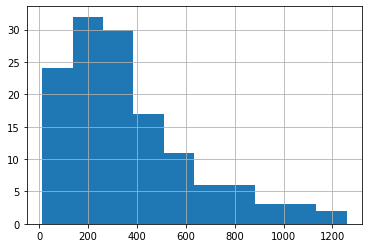

In [ ]:
count_df = df_simple.groupby('aisle')['product_name'].nunique()
count_df.hist()
# count_df[count_df>1]

In [ ]:
df_simple['aisle'].value_counts()

missing                         1258
candy chocolate                 1246
ice cream ice                   1091
vitamins supplements            1038
yogurt                          1026
                                ... 
frozen juice                      47
baby accessories                  44
packaged produce                  32
bulk grains rice dried goods      26
bulk dried fruits vegetables      12
Name: aisle, Length: 134, dtype: int64

In [ ]:
df_simple = df_simple[df_simple['aisle']!= 'missing']

In [ ]:
df_simple['aisle'].value_counts()

candy chocolate                 1246
ice cream ice                   1091
vitamins supplements            1038
yogurt                          1026
chips pretzels                   989
                                ... 
frozen juice                      47
baby accessories                  44
packaged produce                  32
bulk grains rice dried goods      26
bulk dried fruits vegetables      12
Name: aisle, Length: 133, dtype: int64

In [ ]:
num_labels = df_simple['aisle'].nunique()

num_labels

# features = Features({"product_name": Value("string"), "aisle": ClassLabel(num_classes=num_labels, names=unique_labels)})
# ds = Dataset.from_pandas(combined_df, features=features)
# ds.features

133

In [ ]:
#encoding labels
unique_labels = df_simple.aisle.unique()
unique_labels
label_dict = {}
for index, unique_label in enumerate(unique_labels):
    label_dict[unique_label] = index
label_dict
df_simple['label'] = df_simple.aisle.replace(label_dict)
df_simple.head()

,product_name,aisle,label
0,Chocolate Sandwich Cookies,cookies cakes,0
1,All-Seasons Salt,spices seasonings,1
2,Robust Golden Unsweetened Oolong Tea,tea,2
3,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,3
4,Green Chile Anytime Sauce,marinades meat preparation,4


### Create a Stratified Training and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_simple.index.values, 
                                                  df_simple.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_simple.label.values)

df_simple['data_type'] = ['not_set']*df_simple.shape[0]

df_simple.loc[X_train, 'data_type'] = 'train'
df_simple.loc[X_val, 'data_type'] = 'val'

df_simple.groupby(['aisle', 'label', 'data_type']).count()

product_name
aisle                         label data_type              
air fresheners candles        106   train               302
                                    val                  53
asian foods                   36    train               514
                                    val                  91
baby accessories              97    train                37
...                                                     ...
water seltzer sparkling water 9     val                  52
white wines                   70    train               125
                                    val                  22
yogurt                        8     train               872
                                    val                 154

[266 rows x 1 columns]

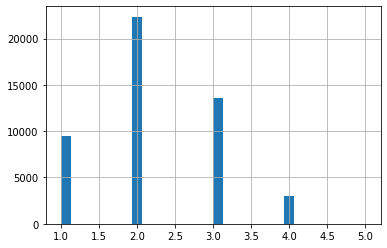

In [ ]:
seq_lens= [len(i.split()) for i in df_simple['aisle']]
pd.Series(seq_lens).hist(bins=30)

In [ ]:
df_simple['label'].value_counts(normalize = True)

73     0.025728
77     0.022527
21     0.021433
8      0.021185
28     0.020421
         ...   
129    0.000970
97     0.000909
131    0.000661
115    0.000537
126    0.000248
Name: label, Length: 133, dtype: float64

### Bert Tokenizer and Encoding the Data

In [ ]:
#load pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", #bert-based-uncase is a smaller pre-trained model
                                                      num_labels=len(label_dict), # indicates the number of potenial output labels (product subcategories)
                                                      output_attentions=False,
                                                      output_hidden_states=False)
#freeze all layers of the model before fine tuning
for param in model.bert.parameters():
    param.requires_grad = False

model.to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
##adapted from: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
## Tokenizer, Instantiate a pre-trained BERT model configuration to encode our data.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True) #constructs a Bert tokenizer based on WordPiece
                                          
#convert train data product names to encoded form
encoded_data_train = tokenizer.batch_encode_plus(
    df_simple[df_simple.data_type=='train'].product_name.values, #specifying the column name to encode
    add_special_tokens=True, #means the sequences will be encoded with the special tokens relative to their model.
    return_attention_mask=True,#When batching sequences together, we set return_attention_mask=True, so it will return the attention mask according to the specific tokenizer defined by the max_length attribute.
    pad_to_max_length=True, #pad all the product names to certain maximum length.
    max_length=10, #pad all the product names to certain maximum length. we checked above and most product names are 5 words or less 
    return_tensors='pt', #to return pytorch
    truncation=True
)


#convert validation data product names to encoded form
encoded_data_val = tokenizer.batch_encode_plus(
    df_simple[df_simple.data_type=='val'].product_name.values, 
    add_special_tokens=True, #means the sequences will be encoded with the special tokens relative to their model.
    return_attention_mask=True, #When batching sequences together, we set return_attention_mask=True, so it will return the attention mask according to the specific tokenizer defined by the max_length attribute. This is 0s and 1s and it tells the model which tokens to pay attention to, the 1s
    pad_to_max_length=True, #pad all the product names to the length of the maximum length of the text.
    max_length=10, 
    return_tensors='pt', #to return pytorch
    truncation=True
)

# we need to split the data into input_ids, attention_masks and labels.
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_simple[df_simple.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_simple[df_simple.data_type=='val'].label.values)

#after we get encoded data set, we can create training data and validation data
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

### Data Loader

In [ ]:
# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset.
# We use RandomSampler for training and SequentialSampler for validation.
#pass batches of train data and validation data as input to the model during the training phase.
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

### Optimizer & Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

#To construct an optimizer, we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, epsilon, etc.
optimizer = AdamW(model.parameters(),
                  lr=1e-8, 
                  eps=1e-8)
                  
epochs = 10

#Create a schedule with a learning rate that decreases linearly from the initial learning rate
#set in the optimizer to 0, after a warmup period during which it increases linearly from 0 
#to the initial learning rate set in the optimizer.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

### Performance Metrics

In [ ]:
#Create functions for Performance Metrics
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### Model Evaluation Function

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  

In [ ]:
# specify GPU
# device = torch.device("cuda")

## Fine Tuning Model

In [ ]:
# running/fine-tuning model
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 1
Training loss: 4.956898825244562
Validation loss: 4.958187824801395
F1 Score (Weighted): 0.0007482070123843649


Epoch 2:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 2
Training loss: 4.954906758543309
Validation loss: 4.957101675502041
F1 Score (Weighted): 0.0007502415950006798


Epoch 3:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 3
Training loss: 4.953235537300021
Validation loss: 4.956145778036954
F1 Score (Weighted): 0.0007513387915026795


Epoch 4:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 4
Training loss: 4.954337693594552
Validation loss: 4.955321370509633
F1 Score (Weighted): 0.0007522022954894799


Epoch 5:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 5
Training loss: 4.9520608595201185
Validation loss: 4.954626215131659
F1 Score (Weighted): 0.0007577286340743156


Epoch 6:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 6
Training loss: 4.951618412065247
Validation loss: 4.9540586387901975
F1 Score (Weighted): 0.0007594801539981857


Epoch 7:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 7
Training loss: 4.9520835183624525
Validation loss: 4.9536229497508
F1 Score (Weighted): 0.0007598172505926623


Epoch 8:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 8
Training loss: 4.951930102397975
Validation loss: 4.953328657568547
F1 Score (Weighted): 0.000760248459328232


Epoch 9:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 9
Training loss: 4.951308492736105
Validation loss: 4.953179144022758
F1 Score (Weighted): 0.000760248459328232


Epoch 10:   0%|          | 0/1287 [00:00<?, ?it/s]


Epoch 10
Training loss: 4.951620283475104
Validation loss: 4.95315180535902
F1 Score (Weighted): 0.000760248459328232


### Loading and Evaluating

In [ ]:
#test model on baseline
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/finetuned_BERT_epoch_50.model', map_location=torch.device('cuda')))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RuntimeError: ignored

In [ ]:
#evaluate by category
#cosine similarity to evaluate predictions

In [ ]:
#read in our dataset
ny_df = pd.read_csv('/content/drive/MyDrive/capstone project - shared/datasets/updated_df.csv')
ny_df.head()

In [ ]:
#test model on our dataset
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
# #take all of product names
# tokenize using same tokenizer
# pass that into the model for predictions
model.load_state_dict(torch.load('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

model.predict

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

FileNotFoundError: ignored

## Other Method

In [ ]:
#write out list of unique values
unique_labels.to_csv("/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/subcategory_list.csv")

In [ ]:
num_labels

In [ ]:
#bash code to write at py file
%%writefile '/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/upload.py'
"""TODO(squad_v2): Add a description here."""


import json

import datasets
from datasets.tasks import TextClassification
import pandas as pd


# TODO(groceries): BibTeX citation
_CITATION = """\
The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <date>
}
"""

_DESCRIPTION = """\
Dataset of 3 million Instacart orders, open sourced. Contains info about product name, aisle and department which is all we will be using to train this model"
"""

_URLS = {
    "train": '/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/train_v3.json',
    "dev": '/content/gdrive/My Drive/capstone project - shared/datasets/BERT_Model/test_v3.json',
}

subcategories = pd.read_csv('gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/subcategory_list.csv')
class GroceryClassifierConfig(datasets.BuilderConfig):
    """BuilderConfig for GroceryClassifier."""

    def __init__(self, **kwargs):
        """BuilderConfig for GroceryClassifier.
        Args:
          **kwargs: keyword arguments forwarded to super.
        """
        super(GroceryClassifierConfig, self).__init__(**kwargs)


class GroceryClassifier(datasets.GeneratorBasedBuilder):
    """TODO(squad_v2): Short description of my dataset."""

    # TODO(squad_v2): Set up version.
    BUILDER_CONFIGS = [
        GroceryClassifierConfig(name="grocery_classifier", version=datasets.Version("1.0.0"), description="grocery_classifier plain text version 1"),
    ]

    def _info(self):
        # TODO(squad_v2): Specifies the datasets.DatasetInfo object
        return datasets.DatasetInfo(
            # This is the description that will appear on the datasets page.
            description=_DESCRIPTION,
            # datasets.features.FeatureConnectors
            features=datasets.Features(
                {
                    "product_id": datasets.Value("int64"),
                    "product_name": datasets.Value("string"),
                    "aisle_id": datasets.Value("int64"),
                    "department_id": datasets.Value("int64"),
                    "department": datasets.Value("string"),
                    "aisle": datasets.ClassLabel(num_classes=subcategories["0"].nunique(), names=list(subcategories["0"].unique()))
                    # These are the features of your dataset like images, labels ...
                }
            ),
            # If there's a common (input, target) tuple from the features,
            # specify them here. They'll be used if as_supervised=True in
            # builder.as_dataset.
            supervised_keys=None,
            # Homepage of the dataset for documentation
            homepage="https://huggingface.co/datasets/mm9819/Grocery_Subcategories",
            citation=_CITATION,
            task_templates=[
                TextClassification(
                    text_column="product_name", label_column="aisle"
                )
            ],
        )

    def _split_generators(self, dl_manager):
        """Returns SplitGenerators."""
        # TODO(squad_v2): Downloads the data and defines the splits
        # dl_manager is a datasets.download.DownloadManager that can be used to
        # download and extract URLs
        urls_to_download = _URLS
        downloaded_files = dl_manager.download_and_extract(urls_to_download)

        return [
            datasets.SplitGenerator(name=datasets.Split.TRAIN, gen_kwargs={"filepath": downloaded_files["train"]}),
            datasets.SplitGenerator(name=datasets.Split.VALIDATION, gen_kwargs={"filepath": downloaded_files["dev"]}),
        ]

  

In [ ]:
dataset = load_dataset('/content/gdrive/MyDrive/capstone project - shared/datasets/BERT_Model/upload.py')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python3 /upload_py.py

In [ ]:
import pprint

In [ ]:
dataset = load_dataset(mm9819/Grocery_Subcategories)

### Run Model

In [ ]:
dataset = load_dataset('mm9819/Grocery_Subcategories')

@article{turc2019,
  title={Well-Read Students Learn Better: On the Importance of Pre-training Compact Models},
  author={Turc, Iulia and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina},
  journal={arXiv preprint arXiv:1908.08962v2 },
  year={2019}
}

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
!pip install git+https://github.com/huggingface/transformers

In [ ]:
!pip install datasets

In [ ]:
import torch
import datetime
import json
import os
import time
import datasets
import pprint
import random
import string
import sys
import transformers

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
!git clone https://github.com/huggingface/transformers.git

In [ ]:
%cd /content/transformers/examples/pytorch/text-classification/

In [ ]:
!pip install evaluate

In [ ]:
#pull pretrained model and retraining it Instacart data
# !python run_glue.py \
#   --model_name_or_path bert-base-uncased \
#   --dataset_name train_data \
#   --do_train \
#   --do_eval \
#   --per_device_train_batch_size 24 \
#   --learning_rate 3e-5 \
#   --num_train_epochs 2 \
#   --max_seq_length 384 \
#   --doc_stride 128 \
#   --version_2_with_negative \
#   --output_dir /tmp/grocery_cat/
TASK_NAME='mrpc'


!python run_glue.py \
  --model_name_or_path bert-base-cased \
  --dataset_name dataset \
  --task_name mrpc \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir /tmp/BERT_Model/mrpc

### Save MRPC BERT model to Hugging Face

In [ ]:

#create model repo
!sudo apt-get install git-lfs

In [ ]:
#login to Hugging Face and create new repo
!huggingface-cli login
!huggingface-cli repo create Grocery_mrpc_BERT

In [ ]:
#clone model locally
!git clone https://huggingface.co/mm9819/Grocery_mrpc_BERT

In [ ]:
#move into directory
!cd Grocery_mrpc_BERT/
#configure
!git lfs install
!git config --global user.email "mm9819@berkeley.edu"
!git config --global user.name "mariahsm"

In [ ]:
#upload model
!git add .
!git commit -m "grocery_model_commit"


In [ ]:
!git push

In [ ]:
#trying with RTE
!python run_glue.py \
  --model_name_or_path bert-base-cased \
  --dataset_name mm9819/Grocery_Subcategories/train_data \
  --task_name rte \
  --do_train \
  --do_eval \
  --max_seq_length 128 \
  --per_device_train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3 \
  --output_dir /tmp/rte_model_v2/

In [ ]:
#pull retrained model back from Hugginface and run it with our grocery data
